## Dual Tank Level Control
The objective of this Project is to automatically maintain a liquid level in the lower of two dual gravity drained tanks.
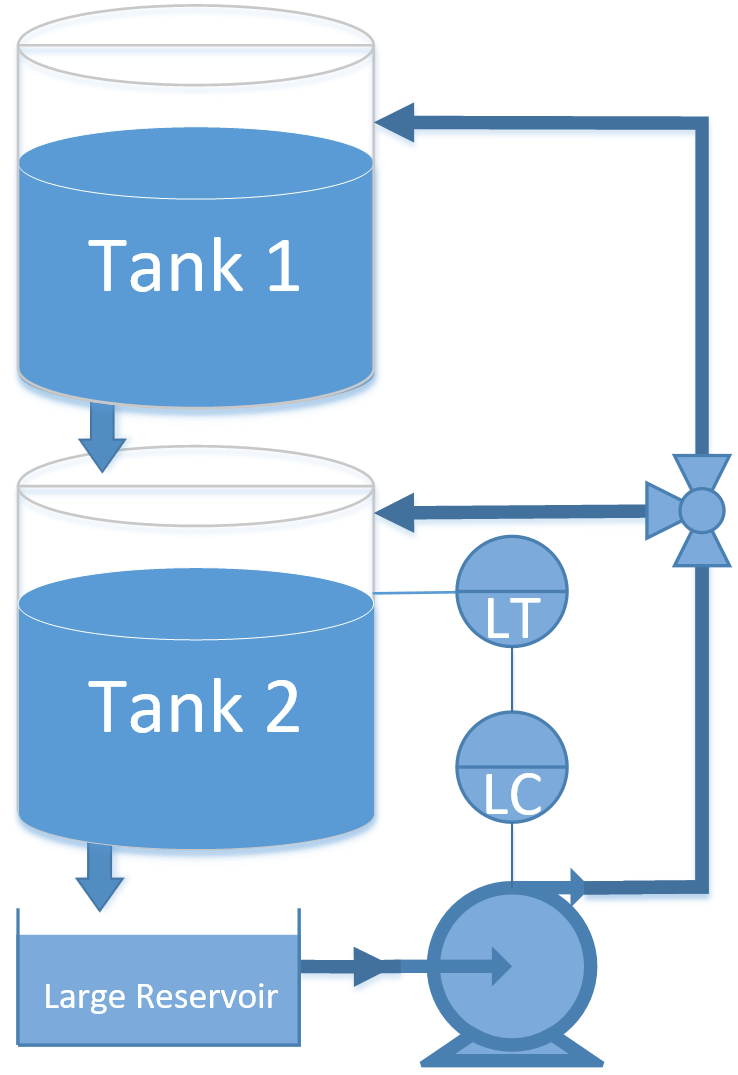

The exercise involves creating a dynamic first-order model, obtaining tuning parameters, and adjusting the PID tuning to achieve acceptable performance.

Step Test with Graphical FOPDT Fit For the gravity drained tank problem, conduct a step test by manipulating the pump rate and recording the level in the bottom tank. Use graphical methods to obtain a FOPDT model and report the values of the three FOPDT parameters.

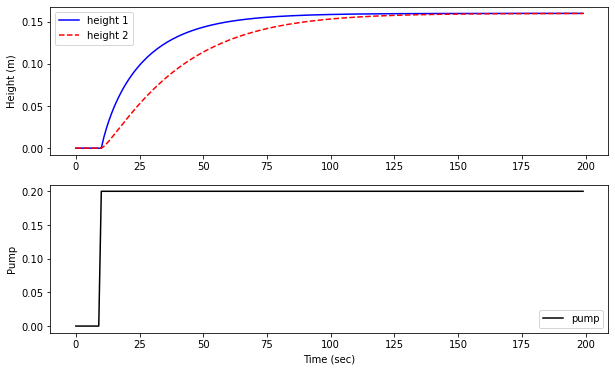

In [1]:
from IPython import display
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint

# animate plots?
animate=True # True / False

def tank(levels,t,pump,valve):
    h1 = max(0.0,levels[0])
    h2 = max(0.0,levels[1])
    c1 = 0.08 # inlet valve coefficient
    c2 = 0.04 # tank outlet coefficient
    dhdt1 = c1 * (1.0-valve) * pump - c2 * np.sqrt(h1)
    dhdt2 = c1 * valve * pump + c2 * np.sqrt(h1) - c2 * np.sqrt(h2)
    # overflow conditions
    if h1>=1.0 and dhdt1>0.0:
        dhdt1 = 0
    if h2>=1.0 and dhdt2>0.0:
        dhdt2 = 0
    dhdt = [dhdt1,dhdt2]
    return dhdt

# Initial conditions (levels)
h0 = [0.0,0.0]

# Time points to report the solution
tf = 200
t = np.linspace(0,tf,tf+1)
# Inputs that can be adjusted
pump = np.zeros((tf+1))
# pump can operate between 0 and 1
pump[10:] = 0.2
# valve = 0, directly into top tank
# valve = 1, directly into bottom tank
valve = 0.0 
# Record the solution
y = np.empty((tf+1,2))
y[0,:] = h0

plt.figure(figsize=(10,6))

if animate:
    plt.ion()
    plt.show()

# Simulate the tank step test
for i in range(tf):
    # Specify the pump and valve
    inputs = (pump[i],valve)
    # Integrate the model
    h = odeint(tank,h0,[0,1],inputs)
    # Record the result
    y[i+1,:] = h[-1,:]
    # Reset the initial condition
    h0 = h[-1,:]

    # plot results
    if animate:
        display.clear_output(wait=True)
        plt.figure(figsize=(10,6))   
        plt.subplot(2,1,1)
        plt.plot(t[0:i+1],y[0:i+1,0],'b-',label='height 1')
        plt.plot(t[0:i+1],y[0:i+1,1],'r--',label='height 2')
        plt.ylabel('Height (m)')
        plt.legend(loc='best')
        plt.subplot(2,1,2)
        plt.plot(t[0:i+1],pump[0:i+1],'k-',label='pump')
        plt.legend(loc='best')
        plt.ylabel('Pump')
        plt.xlabel('Time (sec)')
        plt.pause(0.01)

# Export step test data file
# reshape as column vectors
time_col = t.reshape(-1,1)
pump_col = pump.reshape(-1,1)
h2_col = y[:,1].reshape(-1,1)
my_data = np.concatenate((time_col,pump_col,h2_col), axis=1)
np.savetxt('step_test_data.txt',my_data,delimiter=',',comments="",header='time,u,y')

if not animate:
    # Plot results
    plt.subplot(2,1,1)
    plt.plot(t,y[:,0],'b-',label='height 1')
    plt.plot(t,y[:,1],'r--',label='height 2')
    plt.ylabel('Height (m)')
    plt.legend(loc='best')
    plt.subplot(2,1,2)
    plt.plot(t,pump,'k-',label='pump')
    plt.legend(loc='best')
    plt.ylabel('Pump')
    plt.xlabel('Time (sec)')
    plt.show()

## Fit FOPDT with Optimization

Use optimization to obtain the same parameters in the FOPDT model (see example optimization code) or use PIDTuner.com. Compare the optimized values with those obtained graphically. Are they the same? Why or why not? Which values would you use and why?


Initial SSE Objective: 13.212485100542835
Final SSE Objective: 0.0002757943512066465
Kp: 0.8065003131757963
taup: 30.37531477020779
thetap: 3.0041455212762194


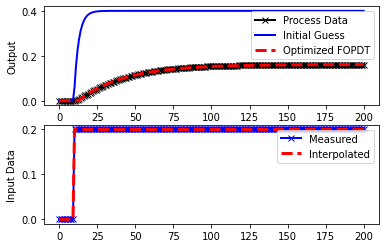

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.integrate import odeint
from scipy.optimize import minimize
from scipy.interpolate import interp1d

# Import CSV data file
# Column 1 = time (t)
# Column 2 = input (u)
# Column 3 = output (yp)
file = 'step_test_data.txt'
data = pd.read_csv(file)
t = data['time'].values - data['time'].values[0]
u = data['u'].values
yp = data['y'].values
u0 = u[0]
yp0 = yp[0]

# specify number of steps
ns = len(t)
delta_t = t[1]-t[0]
# create linear interpolation of the u data versus time
uf = interp1d(t,u)

# define first-order plus dead-time approximation    
def fopdt(y,t,uf,Km,taum,thetam):
    # arguments
    #  y      = output
    #  t      = time
    #  uf     = input linear function (for time shift)
    #  Km     = model gain
    #  taum   = model time constant
    #  thetam = model time constant
    # time-shift u
    try:
        if (t-thetam) <= 0:
            um = uf(0.0)
        else:
            um = uf(t-thetam)
    except:
        #print('Error with time extrapolation: ' + str(t))
        um = u0
    # calculate derivative
    dydt = (-(y-yp0) + Km * (um-u0))/taum
    return dydt

# simulate FOPDT model with x=[Km,taum,thetam]
def sim_model(x):
    # input arguments
    Km = x[0]
    taum = x[1]
    thetam = x[2]
    # storage for model values
    ym = np.zeros(ns)  # model
    # initial condition
    ym[0] = yp0
    # loop through time steps    
    for i in range(0,ns-1):
        ts = [t[i],t[i+1]]
        y1 = odeint(fopdt,ym[i],ts,args=(uf,Km,taum,thetam))
        ym[i+1] = y1[-1]
    return ym

# define objective
def objective(x):
    # simulate model
    ym = sim_model(x)
    # calculate objective
    obj = 0.0
    for i in range(len(ym)):
        obj = obj + (ym[i]-yp[i])**2    
    # return result
    return obj

# initial guesses
x0 = np.zeros(3)
x0[0] = 2.0 # Km
x0[1] = 3.0 # taum
x0[2] = 0.0 # thetam

# show initial objective
print('Initial SSE Objective: ' + str(objective(x0)))

# optimize Km, taum, thetam
solution = minimize(objective,x0)

# Another way to solve: with bounds on variables
#bnds = ((0.4, 0.6), (1.0, 10.0), (0.0, 30.0))
#solution = minimize(objective,x0,bounds=bnds,method='SLSQP')
x = solution.x

# show final objective
print('Final SSE Objective: ' + str(objective(x)))

print('Kp: ' + str(x[0]))
print('taup: ' + str(x[1]))
print('thetap: ' + str(x[2]))

# calculate model with updated parameters
ym1 = sim_model(x0)
ym2 = sim_model(x)
# plot results
plt.figure()
plt.subplot(2,1,1)
plt.plot(t,yp,'kx-',linewidth=2,label='Process Data')
plt.plot(t,ym1,'b-',linewidth=2,label='Initial Guess')
plt.plot(t,ym2,'r--',linewidth=3,label='Optimized FOPDT')
plt.ylabel('Output')
plt.legend(loc='best')
plt.subplot(2,1,2)
plt.plot(t,u,'bx-',linewidth=2)
plt.plot(t,uf(t),'r--',linewidth=3)
plt.legend(['Measured','Interpolated'],loc='best')
plt.ylabel('Input Data')
plt.show()

## Repeat with Doublet Test

Repeat the test using a doublet test instead of a step test. Fit FOPDT parameters using optimization of the three parameters. Why is it important to obtain values above and below the steady state value for nonlinear processes?

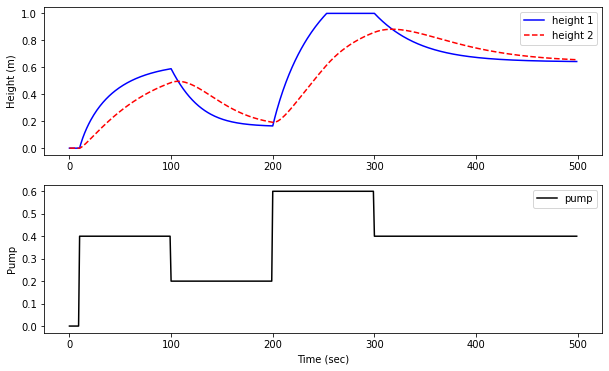

In [3]:
from IPython import display
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint

def tank(levels,t,pump,valve):
    h1 = max(0.0,levels[0])
    h2 = max(0.0,levels[1])
    c1 = 0.08 # inlet valve coefficient
    c2 = 0.04 # tank outlet coefficient
    dhdt1 = c1 * (1.0-valve) * pump - c2 * np.sqrt(h1)
    dhdt2 = c1 * valve * pump + c2 * np.sqrt(h1) - c2 * np.sqrt(h2)
    # overflow conditions
    if h1>=1.0 and dhdt1>0.0:
        dhdt1 = 0
    if h2>=1.0 and dhdt2>0.0:
        dhdt2 = 0
    dhdt = [dhdt1,dhdt2]
    return dhdt

# Initial conditions (levels)
h0 = [0.0,0.0]

# Time points to report the solution
tf = 500
t = np.linspace(0,tf,tf+1)
# Inputs that can be adjusted
pump = np.zeros((tf+1))
# pump can operate between 0 and 1
pump[10:] = 0.4
pump[100:] = 0.2
pump[200:] = 0.6
pump[300:] = 0.4

# valve = 0, directly into top tank
# valve = 1, directly into bottom tank
valve = 0.0 
# Record the solution
y = np.empty((tf+1,2))
y[0,:] = h0

plt.figure(figsize=(10,6))

if animate:
    plt.ion()
    plt.show()

# Simulate the tank step test
for i in range(tf):
    # Specify the pump and valve
    inputs = (pump[i],valve)
    # Integrate the model
    h = odeint(tank,h0,[0,1],inputs)
    # Record the result
    y[i+1,:] = h[-1,:]
    # Reset the initial condition
    h0 = h[-1,:]

    # plot results
    if animate:
        display.clear_output(wait=True)
        plt.figure(figsize=(10,6))   
        plt.subplot(2,1,1)
        plt.plot(t[0:i+1],y[0:i+1,0],'b-',label='height 1')
        plt.plot(t[0:i+1],y[0:i+1,1],'r--',label='height 2')
        plt.ylabel('Height (m)')
        plt.legend(loc='best')
        plt.subplot(2,1,2)
        plt.plot(t[0:i+1],pump[0:i+1],'k-',label='pump')
        plt.legend(loc='best')
        plt.ylabel('Pump')
        plt.xlabel('Time (sec)')
        plt.pause(0.01)

# Export step test data file
# reshape as column vectors
time_col = t.reshape(-1,1)
pump_col = pump.reshape(-1,1)
h2_col = y[:,1].reshape(-1,1)
my_data = np.concatenate((time_col,pump_col,h2_col), axis=1)
np.savetxt('doublet_test_data.txt',my_data,delimiter=',',comments="",header='time,u,y')

if not animate:
    # Plot results
    plt.subplot(2,1,1)
    plt.plot(t,y[:,0],'b-',label='height 1')
    plt.plot(t,y[:,1],'r--',label='height 2')
    plt.ylabel('Height (m)')
    plt.legend(loc='best')
    plt.subplot(2,1,2)
    plt.plot(t,pump,'k-',label='pump')
    plt.legend(loc='best')
    plt.ylabel('Pump')
    plt.xlabel('Time (sec)')
    plt.show()

Initial SSE Objective: 69.4479397124355
Final SSE Objective: 2.3395660922100885
Kp: 1.6183733668731293
taup: 55.719430450766566
thetap: 15.818511484422789


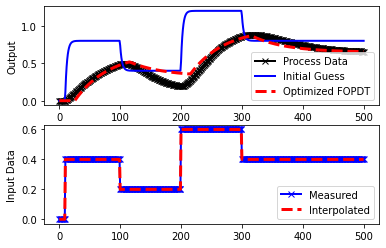

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.integrate import odeint
from scipy.optimize import minimize
from scipy.interpolate import interp1d

# Import CSV data file
# Column 1 = time (t)
# Column 2 = input (u)
# Column 3 = output (yp)
file = 'doublet_test_data.txt'
data = pd.read_csv(file)
t = data['time'].values - data['time'].values[0]
u = data['u'].values
yp = data['y'].values
u0 = u[0]
yp0 = yp[0]

# specify number of steps
ns = len(t)
delta_t = t[1]-t[0]
# create linear interpolation of the u data versus time
uf = interp1d(t,u)

# define first-order plus dead-time approximation    
def fopdt(y,t,uf,Km,taum,thetam):
    # arguments
    #  y      = output
    #  t      = time
    #  uf     = input linear function (for time shift)
    #  Km     = model gain
    #  taum   = model time constant
    #  thetam = model time constant
    # time-shift u
    try:
        if (t-thetam) <= 0:
            um = uf(0.0)
        else:
            um = uf(t-thetam)
    except:
        #print('Error with time extrapolation: ' + str(t))
        um = u0
    # calculate derivative
    dydt = (-(y-yp0) + Km * (um-u0))/taum
    return dydt

# simulate FOPDT model with x=[Km,taum,thetam]
def sim_model(x):
    # input arguments
    Km = x[0]
    taum = x[1]
    thetam = x[2]
    # storage for model values
    ym = np.zeros(ns)  # model
    # initial condition
    ym[0] = yp0
    # loop through time steps    
    for i in range(0,ns-1):
        ts = [t[i],t[i+1]]
        y1 = odeint(fopdt,ym[i],ts,args=(uf,Km,taum,thetam))
        ym[i+1] = y1[-1]
    return ym

# define objective
def objective(x):
    # simulate model
    ym = sim_model(x)
    # calculate objective
    obj = 0.0
    for i in range(len(ym)):
        obj = obj + (ym[i]-yp[i])**2    
    # return result
    return obj

# initial guesses
x0 = np.zeros(3)
x0[0] = 2.0 # Km
x0[1] = 3.0 # taum
x0[2] = 0.0 # thetam

# show initial objective
print('Initial SSE Objective: ' + str(objective(x0)))

# optimize Km, taum, thetam
solution = minimize(objective,x0)

# Another way to solve: with bounds on variables
#bnds = ((0.4, 0.6), (1.0, 10.0), (0.0, 30.0))
#solution = minimize(objective,x0,bounds=bnds,method='SLSQP')
x = solution.x

# show final objective
print('Final SSE Objective: ' + str(objective(x)))

print('Kp: ' + str(x[0]))
print('taup: ' + str(x[1]))
print('thetap: ' + str(x[2]))

# calculate model with updated parameters
ym1 = sim_model(x0)
ym2 = sim_model(x)
# plot results
plt.figure()
plt.subplot(2,1,1)
plt.plot(t,yp,'kx-',linewidth=2,label='Process Data')
plt.plot(t,ym1,'b-',linewidth=2,label='Initial Guess')
plt.plot(t,ym2,'r--',linewidth=3,label='Optimized FOPDT')
plt.ylabel('Output')
plt.legend(loc='best')
plt.subplot(2,1,2)
plt.plot(t,u,'bx-',linewidth=2)
plt.plot(t,uf(t),'r--',linewidth=3)
plt.legend(['Measured','Interpolated'],loc='best')
plt.ylabel('Input Data')
plt.show()

## Design and Tune PI Controller

Use an appropriate tuning rule (either ITAE or IMC) to obtain a starting value for the controller gain  and integral reset time  of a PI controller. Implement the PI controller (with anti-reset windup) and tune the controller constants (adjust up or down) until an acceptable response is achieved for step changes in the set point. Include plots of with initial values, tuned values, and a justification of your criteria for an acceptable response. Remember to define your criteria in terms of rise time, peak time, overshoot ratio, damping ratio and settling time.

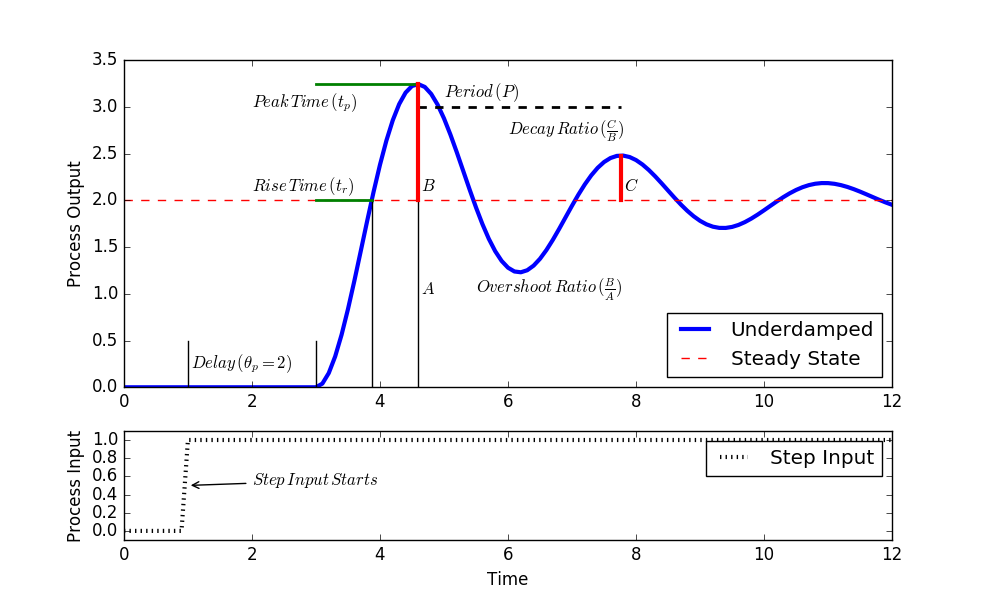

In [6]:
!pip install simple_pid

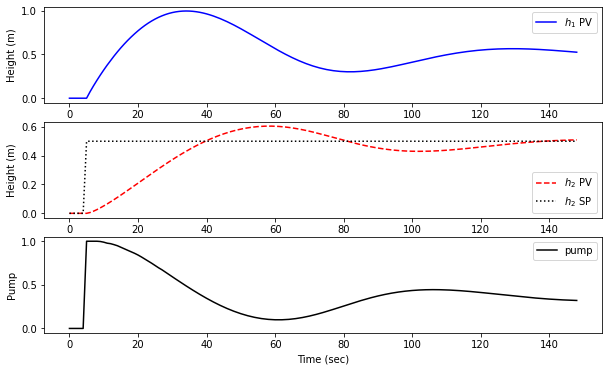

In [7]:
from IPython import display
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint
from simple_pid import PID  # pip install simple_pid
import time

# create PID controller
# op = op_bias + Kc * e + Ki * ei + Kd * ed
#      with ei = error integral
#      with ed = error derivative
Kc = 2.0   # Controller gain (Kc)
Ki = 0.03  # Controller integral parameter (Kc/tauI)
Kd = 0.0   # Controller derivative parameter (Kc*tauD)
pid = PID(Kc,Ki,Kd)
# lower and upper controller output limits
oplo = 0.0
ophi = 1.0
pid.output_limits = (oplo,ophi)
# PID sample time
pid.sample_time = 1.0

def tank(levels,t,pump,valve):
    h1 = max(0.0,levels[0])
    h2 = max(0.0,levels[1])
    c1 = 0.08 # inlet valve coefficient
    c2 = 0.04 # tank outlet coefficient
    dhdt1 = c1 * (1.0-valve) * pump - c2 * np.sqrt(h1)
    dhdt2 = c1 * valve * pump + c2 * np.sqrt(h1) - c2 * np.sqrt(h2)
    # overflow conditions
    if h1>=1.0 and dhdt1>0.0:
        dhdt1 = 0
    if h2>=1.0 and dhdt2>0.0:
        dhdt2 = 0
    dhdt = [dhdt1,dhdt2]
    return dhdt

# Initial conditions (levels)
h0 = [0.0,0.0]

# Time points to report the solution
tf = 150
t = np.linspace(0,tf,tf+1)
# Inputs that can be adjusted
pump = np.zeros((tf+1))

# valve = 0, directly into top tank
# valve = 1, directly into bottom tank
valve = 0.0 
# Record the solution
y = np.empty((tf+1,2))
y[0,:] = h0

make_gif = True
try:
    import imageio  # required to make gif animation
except:
    print('install imageio with "pip install imageio" to make gif')
    make_gif=False
if make_gif:
    try:
        import os
        images = []
        os.mkdir('./frames')
    except:
        pass

plt.figure(figsize=(10,6))
plt.ion()

# level setpoint (% full)
sp = np.zeros(tf+1)
sp[5:] = 0.5

# timing functions
tm = np.zeros(tf+1)
sleep_max = 1.01
start_time = time.time()
prev_time = start_time

# Simulate the tank step test
for i in range(tf):
    # PID control
    pid.setpoint=sp[i]
    pump[i] = pid(h0[1])

    # Specify the pump and valve
    inputs = (pump[i],valve)
    # Integrate the model
    h = odeint(tank,h0,[0,1],inputs)
    # Record the result
    y[i+1,:] = h[-1,:]
    # Reset the initial condition
    h0 = h[-1,:]

    # plot results
    display.clear_output(wait=True)
    plt.figure(figsize=(10,6))  
    plt.subplot(3,1,1)
    plt.plot(t[0:i],y[0:i,0],'b-',label=r'$h_1$ PV')
    plt.ylabel('Height (m)')
    plt.legend(loc='best')
    plt.subplot(3,1,2)
    plt.plot(t[0:i],y[0:i,1],'r--',label=r'$h_2$ PV')
    plt.plot(t[0:i],sp[0:i],'k:',label=r'$h_2$ SP')        
    plt.ylabel('Height (m)')
    plt.legend(loc='best')
    plt.subplot(3,1,3)
    plt.plot(t[0:i],pump[0:i],'k-',label='pump')
    plt.legend(loc='best')
    plt.ylabel('Pump')
    plt.xlabel('Time (sec)')
    if make_gif:
        filename='./frames/frame_'+str(1000+i)+'.png'
        plt.savefig(filename)
        images.append(imageio.imread(filename))
    plt.pause(0.01)
    
    # Sleep time
    sleep = sleep_max - (time.time() - prev_time)
    if sleep>=0.01:
        time.sleep(sleep-0.01)
    else:
        time.sleep(0.01)

    # Record time and change in time
    ct = time.time()
    dt = ct - prev_time
    prev_time = ct
    tm[i+1] = ct - start_time

# Export data file
# reshape as column vectors
time_col = t.reshape(-1,1)
pump_col = pump.reshape(-1,1)
h2_col = y[:,1].reshape(-1,1)
my_data = np.concatenate((time_col,pump_col,h2_col), axis=1)
np.savetxt('pid_data.txt',my_data,delimiter=',')

# create animated GIF
if make_gif:
    imageio.mimsave('animate.gif', images)
    #imageio.mimsave('animate.mp4', images)  # requires ffmpeg